In [1]:
import os
import glob
import random
import pytorch_lightning as pl
import torch
import torch.nn as nn
import skimage.io
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.functional import F

from sklearn.model_selection import train_test_split

from pytorch_lightning import loggers as pl_loggers

### Load Tensorboard extension

In [2]:
%load_ext tensorboard

### Define Transforms

In [3]:
MEAN_NORMALIZE = torch.tensor([0.485, 0.456, 0.406])
STD_NORMALIZE = torch.tensor([0.229, 0.224, 0.225])

In [4]:
train_transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225],)
])

validation_transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225],)
])

test_transformation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225],)
])

### Dataset class

In [5]:
class RansomwareDetectionDataset(Dataset):
    def __init__(self, image_paths, class_to_idx, transform=None):
        super().__init__()

        self.image_paths = image_paths
        self.transform = transform
        self.class_to_idx = class_to_idx
    
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        image = skimage.io.imread(image_path)

        label = image_path.split("/")[2]
        label = self.class_to_idx[label]

        if self.transform is not None:
            image = self.transform(image)
        
        return image, label

### Create CNN

In [6]:
class BaselineNetwork(pl.LightningModule):
    def __init__(self, number_of_classes, image_size):
        super().__init__()
        
        self.image_size = image_size
        self.final_size = image_size // 2

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=3, padding=1)
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.dropout = nn.Dropout(0.2)
        self.linear1 = nn.Linear(in_features=12 * self.final_size * self.final_size, out_features=128)
        self.linear2 = nn.Linear(in_features=128, out_features=64)
        self.linear3 = nn.Linear(in_features=64, out_features=number_of_classes)

        self.loss = nn.CrossEntropyLoss()

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = x.flatten(start_dim=1)
        x = F.relu(self.linear1(x))
        x = self.dropout(x)
        x = F.relu(self.linear2(x))
        x = self.linear3(x)

        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        output = self(x)

        loss = self.loss(output, y)
        accuracy = (torch.argmax(output, dim=1) == y).sum() / len(y)

        return {
            "loss": loss,
            "accuracy": accuracy
        }

    def validation_step(self, batch, batch_idx):
        x, y = batch
        output = self(x)

        loss = self.loss(output, y)
        accuracy = (torch.argmax(output,dim=1) == y).sum() / len(y)

        return {
            "loss": loss,
            "accuracy": accuracy
        }

    def training_epoch_end(self, outputs):
        avg_loss = torch.stack([x["loss"] for x in outputs]).mean()
        avg_accuracy = torch.stack([x["accuracy"] for x in outputs]).mean()

        self.log("Loss/train", avg_loss, on_epoch=True, prog_bar=True, logger=True)
        self.log("Accuracy/train", avg_accuracy, on_epoch=True, prog_bar=True, logger=True)

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x["loss"] for x in outputs]).mean()
        avg_accuracy = torch.stack([x["accuracy"] for x in outputs]).mean()

        self.log("Loss/valid", avg_loss, on_epoch=True, prog_bar=True, logger=True)
        self.log("Accuracy/valid", avg_accuracy, on_epoch=True, prog_bar=True, logger=True)

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=0.0001, momentum=0.9)
        lr_scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=0.001, step_size_up=2)
        
        return {
            "optimizer": optimizer,
            "lr_scheduler": lr_scheduler,
            "monitor": "Loss/valid"
        }


### Create train, validation, test sets

In [7]:
def split(split_dataset):
    train_image_paths, valid_image_paths = train_test_split(split_dataset, train_size=0.7, shuffle=True)

    print(f"Train size: {len(train_image_paths)}")
    print(f"Valid size {len(valid_image_paths)}")

    return train_image_paths, valid_image_paths

In [8]:
def index_to_class(classes):
    idx_to_class = {i:j for i, j in enumerate(classes)}
    class_to_idx = {value:key for key,value in idx_to_class.items()}

    return idx_to_class, class_to_idx

In [37]:
def create_path_datasets(benign_path, ransomware_path):
    random.seed(42)

    benign_paths = list()
    ransomware_paths = list()
    classes = list()

    for path in glob.glob(os.path.join(benign_path, "*")):
        classes.append(path.split("/")[2])
        benign_paths.append(path)

    for path in glob.glob(os.path.join(ransomware_path, "*")):
        classes.append(path.split("/")[2])
        ransomware_paths.append(path)

    random.shuffle(benign_paths)
    random.shuffle(ransomware_paths)

    test_benign_image_paths, train_valid_benign_image_paths = benign_paths[:10], benign_paths[10:]
    test_ransomware_image_paths, train_valid_ransomware_image_paths = ransomware_paths[:10], ransomware_paths[10:]

    test_image_paths = test_benign_image_paths + test_ransomware_image_paths
    train_valid_image_paths = train_valid_benign_image_paths[:500] + train_valid_ransomware_image_paths

    classes = list(set(classes))

    print(f"Test dataset len: {len(test_image_paths)}")
    print(f"Train validation dataset len: {len(train_valid_image_paths)}")
    print(f"Path example: {train_valid_image_paths[0]}")
    print(f"Class example: {classes[0]}")

    train_image_paths, valid_image_paths = split(train_valid_image_paths)
    idx_to_class, class_to_idx = index_to_class(classes)

    return train_image_paths, valid_image_paths, test_image_paths, idx_to_class, class_to_idx

### Create train validation dataloader

In [10]:
def create_dataloaders(train_dataset, validation_dataset, batch_size=4):
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, num_workers=0)

    print(f"Train dataloader shape {next(iter(train_dataloader))[0].shape}")
    print(f"Validation dataloader shape {next(iter(validation_dataloader))[0].shape}")

    return train_dataloader, validation_dataloader

### Visualitiona of the data loader data

In [11]:
def visualize_data_loader(train_loader, validation_loader):
    rows = 2
    columns = 2
    fig = plt.figure(figsize=(8, 8))

    train_iter = iter(train_loader)
    valid_iter = iter(validation_loader)

    for index in range(0, 4):
        train_image, train_label = next(train_iter)
        valid_image, valid_label = next(valid_iter)
        ax = fig.add_subplot(rows, columns, index + 1)

        x_train = train_image[0] * STD_NORMALIZE[:, None, None] + MEAN_NORMALIZE[:, None, None]
        plt.imshow(x_train.numpy().transpose(1, 2, 0))

        x_valid = valid_image[0] * STD_NORMALIZE[:, None, None] + MEAN_NORMALIZE[:, None, None]
        plt.imshow(x_valid.numpy().transpose(1, 2, 0))

### Eval Model with test dataset

In [12]:
def eval_model(test_dataloader, idx_to_class, model):
    fig = plt.figure(figsize=(25, 7))
    spec = fig.add_gridspec(ncols=10, nrows=2)

    test_iter = iter(test_dataloader)

    count = 0
    for row in range(2):
        for col in range(10):
            batch, label = next(test_iter)
            pred = model(batch)
            pred = pred.argmax(dim=1)

            ax = fig.add_subplot(spec[row, col])

            x = batch[0] * STD_NORMALIZE[:, None, None] + MEAN_NORMALIZE[:, None, None]
            ax.imshow(x.numpy().transpose(1, 2, 0))
            ax.set_title(f'label: {idx_to_class[label.item()]}, \n pred: {idx_to_class[pred.item()]}')

            count += 1

## Experiment for gramian angular simulation

In [38]:
benign_gaf_path = "features/images/benign/gaf/cache_misses"
ransomware_gaf_path = "features/images/ransomware/gaf/cache_misses"

print("Benign samples", len(glob.glob(os.path.join(benign_gaf_path, "*"))))
print("Ransomware samples", len(glob.glob(os.path.join(ransomware_gaf_path, "*"))))

Benign samples 873
Ransomware samples 873


In [39]:
train_gaf_image_paths, valid_gaf_image_paths, test_gaf_image_paths, gaf_idx_to_class, gaf_class_to_idx = create_path_datasets(benign_gaf_path, ransomware_gaf_path)

train_gaf_dataset = RansomwareDetectionDataset(train_gaf_image_paths, gaf_class_to_idx, transform=train_transformations)
validation_gaf_dataset = RansomwareDetectionDataset(valid_gaf_image_paths, gaf_class_to_idx, transform=validation_transformations)
test_gaf_dataset = RansomwareDetectionDataset(test_gaf_image_paths, gaf_class_to_idx, transform=test_transformation)

print(f"Tensor shape of the image: {train_gaf_dataset[1][0].shape}")
print(f"Label of the image: {gaf_idx_to_class[train_gaf_dataset[1][1]]}")

Test dataset len: 20
Train validation dataset len: 1363
Path example: features/images/benign/gaf/cache_misses/benign_756.jpg
Class example: benign
Train size: 954
Valid size 409
Tensor shape of the image: torch.Size([3, 50, 50])
Label of the image: benign


In [53]:
train_gaf_loader, validation_gaf_loader = create_dataloaders(train_gaf_dataset, validation_gaf_dataset)

Train dataloader shape torch.Size([4, 3, 50, 50])
Validation dataloader shape torch.Size([4, 3, 50, 50])


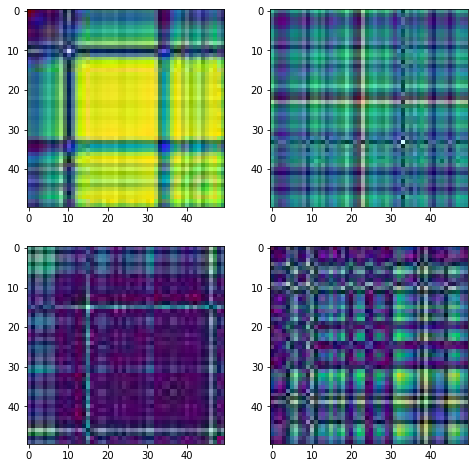

In [54]:
visualize_data_loader(train_gaf_loader, validation_gaf_loader)

In [55]:
gaf_model = BaselineNetwork(number_of_classes=len(gaf_idx_to_class), image_size=50)

In [56]:
logger_gaf = pl_loggers.TensorBoardLogger("logs/", name="CM-GAF")
trainer_gaf = pl.Trainer(max_epochs=10, log_every_n_steps=1, logger=logger_gaf)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [57]:
trainer_gaf.fit(gaf_model, train_dataloaders=train_gaf_loader, val_dataloaders=validation_gaf_loader)


  | Name    | Type             | Params
---------------------------------------------
0 | conv1   | Conv2d           | 168   
1 | conv2   | Conv2d           | 660   
2 | maxpool | MaxPool2d        | 0     
3 | dropout | Dropout          | 0     
4 | linear1 | Linear           | 960 K 
5 | linear2 | Linear           | 8.3 K 
6 | linear3 | Linear           | 130   
7 | loss    | CrossEntropyLoss | 0     
---------------------------------------------
969 K     Trainable params
0         Non-trainable params
969 K     Total params
3.877     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 342/342 [00:08<00:00, 38.25it/s, loss=0.341, v_num=5, Loss/valid=0.479, Accuracy/valid=0.779, Loss/train=0.387, Accuracy/train=0.829]


In [58]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6012 (pid 25844), started 1:09:42 ago. (Use '!kill 25844' to kill it.)

### Verify the model

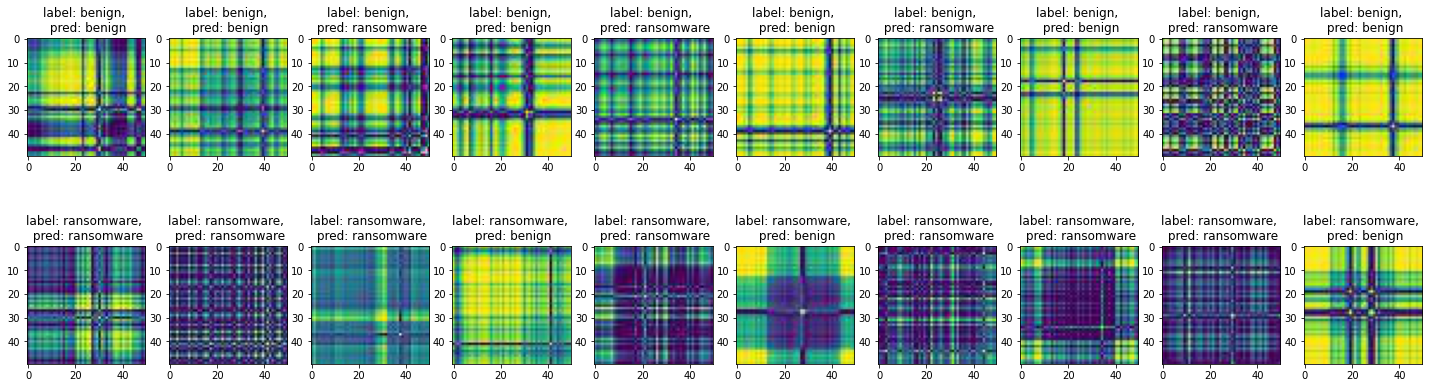

In [59]:
test_gaf_dataloader = DataLoader(test_gaf_dataset, batch_size=1, num_workers=0)
eval_model(test_gaf_dataloader, gaf_idx_to_class, gaf_model)

## Experiment for Markov transition

In [60]:
benign_mtf_path = "features/images/benign/mtf/cache_misses"
ransomware_mtf_path = "features/images/ransomware/mtf/cache_misses"

print("Benign samples", len(glob.glob(os.path.join(benign_mtf_path, "*"))))
print("Ransomware samples", len(glob.glob(os.path.join(ransomware_mtf_path, "*"))))

Benign samples 873
Ransomware samples 873


In [61]:
train_mtf_image_paths, valid_mtf_image_paths, test_mtf_image_paths, mtf_idx_to_class, mtf_class_to_idx = create_path_datasets(benign_mtf_path, ransomware_mtf_path)

train_mtf_dataset = RansomwareDetectionDataset(train_mtf_image_paths, mtf_class_to_idx, transform=train_transformations)
validation_mtf_dataset = RansomwareDetectionDataset(valid_mtf_image_paths, mtf_class_to_idx, transform=validation_transformations)
test_mtf_dataset = RansomwareDetectionDataset(test_mtf_image_paths, mtf_class_to_idx, transform=test_transformation)

print(f"Tensor shape of the image: {train_mtf_dataset[1][0].shape}")
print(f"Label of the image: {mtf_idx_to_class[train_mtf_dataset[1][1]]}")

Test dataset len: 20
Train validation dataset len: 1363
Path example: features/images/benign/mtf/cache_misses/benign_756.jpg
Class example: benign
Train size: 954
Valid size 409
Tensor shape of the image: torch.Size([3, 50, 50])
Label of the image: benign


In [62]:
train_mtf_loader, validation_mtf_loader = create_dataloaders(train_mtf_dataset, validation_mtf_dataset)

Train dataloader shape torch.Size([4, 3, 50, 50])
Validation dataloader shape torch.Size([4, 3, 50, 50])


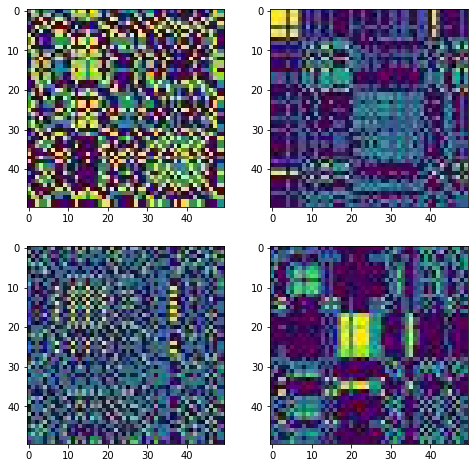

In [63]:
visualize_data_loader(train_mtf_loader, validation_mtf_loader)

In [64]:
mtf_model = BaselineNetwork(number_of_classes=len(mtf_idx_to_class), image_size=50)

In [65]:
logger_mtf = pl_loggers.TensorBoardLogger("logs/", name="CM-MTF")
trainer_mtf = pl.Trainer(max_epochs=10, log_every_n_steps=1, logger=logger_mtf)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [66]:
trainer_mtf.fit(mtf_model, train_dataloaders=train_mtf_loader, val_dataloaders=validation_mtf_loader)

Missing logger folder: logs/CM-MTF

  | Name    | Type             | Params
---------------------------------------------
0 | conv1   | Conv2d           | 168   
1 | conv2   | Conv2d           | 660   
2 | maxpool | MaxPool2d        | 0     
3 | dropout | Dropout          | 0     
4 | linear1 | Linear           | 960 K 
5 | linear2 | Linear           | 8.3 K 
6 | linear3 | Linear           | 130   
7 | loss    | CrossEntropyLoss | 0     
---------------------------------------------
969 K     Trainable params
0         Non-trainable params
969 K     Total params
3.877     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 342/342 [00:10<00:00, 33.17it/s, loss=0.673, v_num=0, Loss/valid=0.663, Accuracy/valid=0.621, Loss/train=0.652, Accuracy/train=0.637]


In [67]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6012 (pid 25844), started 1:14:24 ago. (Use '!kill 25844' to kill it.)

### Verify the model

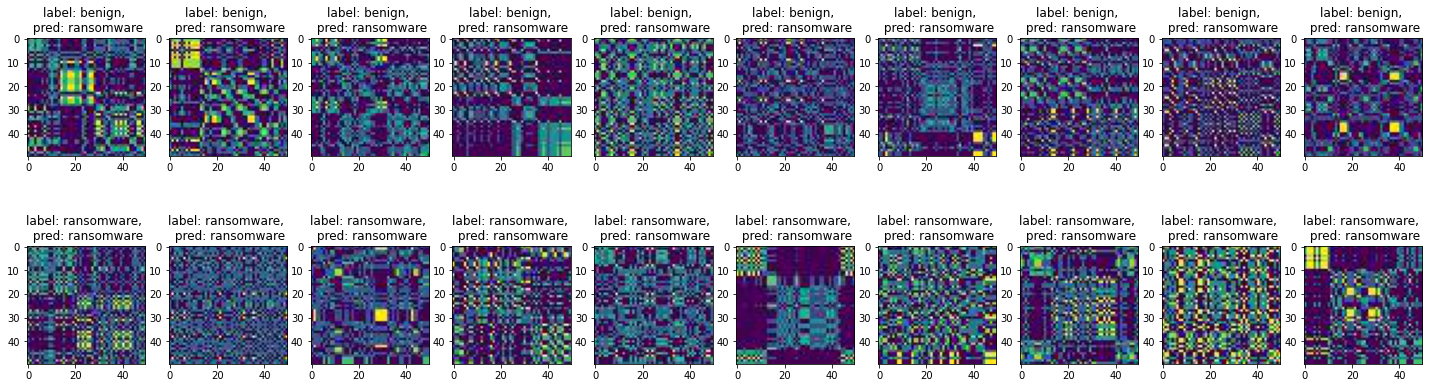

In [68]:
test_mtf_dataloader = DataLoader(test_mtf_dataset, batch_size=1, num_workers=0)
eval_model(test_mtf_dataloader, mtf_idx_to_class, mtf_model)